In [1]:
import pandas as pd
import numpy as np
import astropy
import healpy as hp
import tools

In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
#Cargamos las imagenes de las carpetas fotos_fuentes y fotos_sin_fuentes
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import pandas as pd

from scipy.stats import bootstrap
from tensorflow.keras.preprocessing.image import img_to_array, load_img


In [3]:
# Verifica la disponibilidad de GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs disponibles: ", len(gpus))

# Configura TensorFlow para que use la GPU si está disponible
if gpus:
    try:
        # Establece la memoria de la GPU para que crezca según sea necesario.
        # Esto puede prevenir errores de asignación de memoria en TensorFlow.
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

GPUs disponibles:  1


In [4]:
# Adjust the path to where your file is stored
filepath5 = '../datasets/wmap/newps_5yr_5s_all.dat'
df5 = pd.read_csv(filepath5, delim_whitespace=True, header=None)
df5 = df5.iloc[:, [3, 4, 6, 10,17]]
df5 = df5.rename(columns ={3:'glon',4:'glat',6:'I33',10:'Ierr33'})
df5['ratio'] = df5['Ierr33']


In [5]:
data =df5

In [6]:
wmap = tools.leer_mapa('../datasets/wmap/wmap33.fits')
fwhm_degrees = 0.21
fwhm_radians = np.deg2rad(fwhm_degrees)
# Suavizar el mapa
wmap = hp.smoothing(wmap, fwhm=fwhm_radians)

/home/jovyan/QUIJOTE_CMB/tools.py:23: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  mapa_cmb, header = hp.read_map(ruta_archivo_fits, field=campo, h=True, verbose=False)


KeyboardInterrupt: 

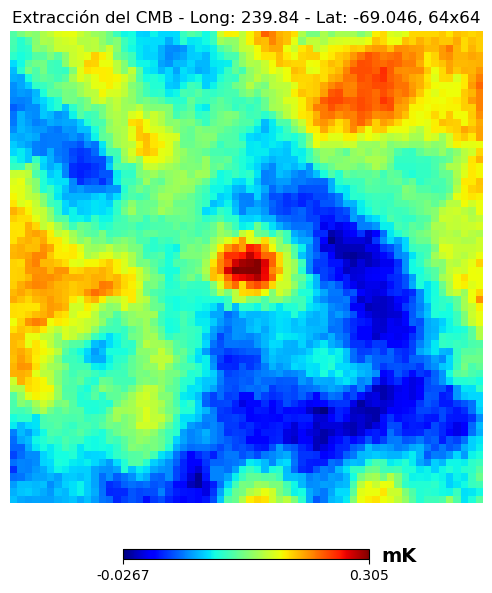

In [7]:
i = 0
for glat,glon in zip(data.glat,data.glon):
        img = tools.extraer_submapa_cmb(wmap,lat = glat,lon = glon,N = 64,res = 6.86,vmin = None,retornar_imagen=True)
        mask = img.mask  # Accede a la máscara
        if np.any(mask):
            continue
        else:
            tools.guardar_imagen_jpg(img,f'../images/wmap/{i}.jpg')
        i +=1

In [8]:
import tensorflow as tf

In [9]:
model = tf.keras.models.load_model('../models/MCD1504_6.h5')

2024-06-01 14:38:56.884088: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62980096 exceeds 10% of free system memory.
2024-06-01 14:38:56.895457: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62980096 exceeds 10% of free system memory.
2024-06-01 14:38:56.910199: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62980096 exceeds 10% of free system memory.
2024-06-01 14:38:57.103383: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62980096 exceeds 10% of free system memory.
/opt/conda/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [10]:
def MCDWMAP(n_iter, path,model):
    resultados = []
    for i in range(0,534):
        try:
            filename = f'{i}.jpg'
            ruta_imagen = os.path.join(path, filename)
            imagen = load_img(ruta_imagen, target_size=(150, 150))  # Ajusta el tamaño según tu modelo
            imagen = img_to_array(imagen) / 255.0  # Reescala si tu modelo lo requiere
            imagen = np.expand_dims(imagen, axis=0)  # Ajusta la forma para el modelo

            predicciones = np.array([model(imagen,training = True)[0] for _ in range(n_iter)])

            # Calcular estadísticas
            media = np.mean(predicciones, axis=0)
            std = np.std(predicciones, axis=0)

            

            # Guardar resultados
            resultados.append({
                'name': i,
                'media': media,
                'std': std,
               
            })
        except FileNotFoundError:
            continue


    # Convertir resultados en DataFrame
    df_resultados = pd.DataFrame(resultados)
    df_resultados['std'] = df_resultados['std'].apply(lambda x : x[0])
    df_resultados['media'] = df_resultados['media'].apply(lambda x : x[0])
    return df_resultados

In [11]:
import os

In [12]:

names = []

accs = []

i = 0
for file_name in os.listdir('../models/'):
        # Filtrar por archivos .h5 que no contienen 'VI' en su nombre
    if file_name.endswith('.h5') and 'VI' not in file_name:
            # Cargar el modelo de Keras
        model_path = os.path.join('../models/', file_name)
        model = tf.keras.models.load_model(model_path)
        
        wmap = MCDWMAP(50, '../images/wmap/',model)
            # Crear el DataFrame del resumen del modelo
        wmap['OK'] = np.where(wmap.media > 0.5,1,0)
        name  = file_name.replace('.h5', '')
        acc = len(wmap.loc[wmap.OK == 1])/len(wmap)
        names.append(name)
        accs.append(acc)
        i +=1
        print(i)

        
        
df = pd.DataFrame({'model':names,'Accuracy': accs})


2024-06-01 14:39:02.915815: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62980096 exceeds 10% of free system memory.


KeyboardInterrupt: 

In [11]:
df.to_csv('../experiments/results/wmap/test_wmap.csv',sep = ';',index = False)

In [15]:
df = df.sort_values(by = 'Accuracy',ascending = False)

In [16]:
df

,model,Accuracy
20,MCD1004_medium_5,0.986867
13,MCSD0604_medium_2,0.986867
14,MCSD0604_medium_3,0.984991
12,MCSD0604_tiny_3,0.984991
6,MCD3003_large_5,0.984991
4,MCD3003_large_3,0.983114
21,MCD1004_medium_7,0.983114
15,MCDC0704_medium_1,0.983114
2,MCD2503_large_1,0.981238
23,MCD1504_medium_8,0.981238
